# Poisson Model simulation of the 2019/20 Premier League season

# Introduction

The 2019/2020 Premier League season was an abnormal one for many reasons, not least the temporary suspension of games due to the coronavirus pandemic. But on the pitch, fans saw Liverpool dominate: winning the league with a record-breaking 7 games to go and by 18 points. Surely a team so dominant in terms of points could not be considered ‘lucky’ to win the league, afterall ‘the table never lies’.

This report will use a model based on the poisson distribution to find win, draw and loss probabilities from Premier League games based on the participating teams expected goals totals. From here the 2019/2020 Premier League season will be simulated to find out how many points a team would have been expected to receive and what position would have been expected to finish based on their underlying performance. The relationship between a team's actual points/league position and underlying performance will then be investigated. 

First the relevant modules are imported.

In [43]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [44]:
import pandas as pd
import matplotlib.pyplot as plt 
import statistics
from scipy.stats import poisson
import scipy
import numpy as np

# Data

The data that will be used for the model comes from: https://github.com/fivethirtyeight/data/tree/master/soccer-spi

The dataset is a CSV containing games from multiple leagues across different years, the data of interest for this report is Premier League data from 2019/20. This data is extracted and entered into a dataframe with 380 rows and 6 columns: Each row represents an individual game and the columns represent: 

- team1; the home team’s name
- team2; the away team’s name
- score1; the number of goals scored by the home team
- score2; the number of goals scored by the away team
- xg1; the total xG for the home team
- xg2; the total xG for the away team


In [45]:
df = pd.read_csv("/Users//ConorSharpe/Downloads/spi_matches (1).csv")

In [46]:
df = df[df.season == 2019]
df = df[df.league == 'Barclays Premier League']
df = df[['team1', 'team2', 'score1', 'score2','xg1','xg2']]
df = df.reset_index()
df = df.drop(columns=['index'])
df.head()

,team1,team2,score1,score2,xg1,xg2
0,Liverpool,Norwich City,4.0,1.0,1.65,0.88
1,West Ham United,Manchester City,0.0,5.0,1.27,2.99
2,Burnley,Southampton,3.0,0.0,0.97,1.16
3,AFC Bournemouth,Sheffield United,1.0,1.0,1.46,1.28
4,Crystal Palace,Everton,0.0,0.0,0.88,1.42


# Poisson Distribution

The poisson distribution gives the probability of a discrete number of events happening in a given amount of time. The single parameter lambda is the expected rate of occurrence. The pmf is given by:

$$p(x)= ({\lambda^x}{e^{-\lambda}})/x!$$ for x greater than or equal to zero and 0 otherwise


In order to use the poisson distribution a number of conditions must be satisfied:
- Time period is fixed
- Multiple events cannot occur at the same time.
- Events must be independent of each other 
- Rate of occurrence is independent of occurence

# Methodology and Model

The poisson distribution will be used to give the probability of a team scoring a given number of goals in a game. Before applying the distribution, its appropriateness must be checked. The first condition is satisfied because the time period is fixed at a game. The length of a game does vary slightly due to added time but this is only minor. The second condition is also satisfied as two goals cannot be scored at the same time. The next two conditions must be assumed to be true. However in reality it is likely that the number of goals scored are not independent of each other.

Next the distribution of goals will be compared to the poisson distribution. Lambda is set to the sample mean for goals scored by a single team.

In [47]:
home_goals = df['score1'].tolist()
away_goals = df['score2'].tolist()
total_goals = home_goals + away_goals

total_goals_mean = statistics.mean(total_goals)

Text(0.5, 1.0, 'Poisson distribution compared to distribution of goals scored by a single team in the Premier League 2018/19')

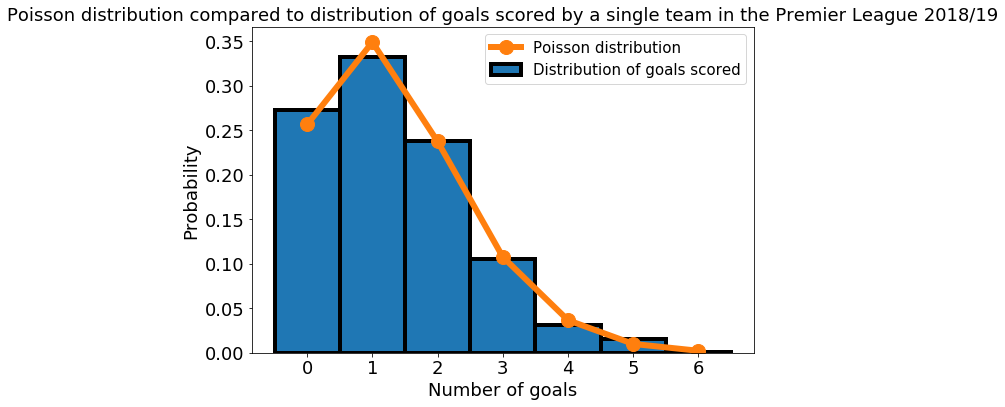

In [59]:
plt.figure(figsize=(9,6))

plt.hist(total_goals , bins = np.arange(-0.5, 7, step=1), 
         edgecolor='black',
         linewidth= 4,
         weights=np.ones(len(total_goals)) / len(total_goals),
         label = 'Distribution of goals scored')

X = np.arange(0, 7)
plt.plot( X, poisson.pmf(X, total_goals_mean  ),linestyle='-', linewidth = 6, marker='o', ms = 14, label = 'Poisson distribution' )

plt.legend(loc='upper right' , prop={'size': 15})

plt.xticks(np.arange(0, 7))
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('Number of goals', fontsize=18)
plt.ylabel('Probability', fontsize=18)

plt.title('Poisson distribution compared to distribution of goals scored by a single team in the Premier League 2018/19', fontsize=18)



The plot shows a close fit between the two distributions. The poisson distribution slightly underestimates the probability of no goals and overestimates the probability of one goal.
The estimation for other numbers of goals are very accurate. Because of this, the poisson distribution appears suitable for modelling goals scored by a single team.

In order to find the probability of a given game ending in a home win, away win or draw, the probability of the teams scoring a given number of goals must be known. To do this the poisson distribution will be used with lambda set to the teams total xG for that game.

The function home_team_prob(xg1) is created, the input xg1 represents the expected goal total of the home team. The model then uses this value to return a list of probabilities relating to the home team scoring that number of goals. For example:

In [49]:
def home_team_prob (xg1):
        prob_list = []
        for j in range(0,10):
            prob = scipy.stats.distributions.poisson.pmf(j, xg1)
            prob_list.append(prob)
    
        return(prob_list)

In [50]:
home_team_prob (1.23)

[0.2922925776808594,
 0.3595198705474571,
 0.22110472038668608,
 0.09065293535854131,
 0.02787577762275145,
 0.0068574412951968615,
 0.001405775465515355,
 0.00024701483179769804,
 3.7978530388896066e-05,
 5.190399153149135e-06]

A team with an xG of 1.23 has a 0.29 chance of scoring no goals, 0.35 chance of one goal, 0.22 chance of two goals, etc 

The function away_team_prob(xg2) does the same for the away team.


In [51]:
 def away_team_prob (xg2):
        prob_list = []
        for j in range(0,10):
            prob = scipy.stats.distributions.poisson.pmf(j,xg2)
            prob_list.append(prob)
    
        return(prob_list)


The function direct_poisson_model(xg1, xg2) again takes the inputs home team expected goals and away team expected goals. The model finds the probability of each team scoring a given number of goals and then finds the probability of every possible scoreline, this is shown in an array. To find the home win probability all values in the lower triangle are summed, to find the away win probability all values in the upper triangle are summed and to find the draw probability the values on the diagonal are summed.


In [52]:
def direct_poisson_model (xg1, xg2):
    
    def home_team_prob (xg1):
        prob_list = []
        for j in range(0,10):
            prob = scipy.stats.distributions.poisson.pmf(j, xg1)
            prob_list.append(prob)
    
        return(prob_list)

    
    def away_team_prob (xg2):
        prob_list = []
        for j in range(0,10):
            prob = scipy.stats.distributions.poisson.pmf(j,xg2)
            prob_list.append(prob)
    
        return(prob_list)


    prob_array = np.outer(np.asarray(home_team_prob(xg1)),np.asarray(away_team_prob(xg2)))
    
    draw = np.diagonal(prob_array).sum() 
    
    home = 0
    for h in range(1,10):
        prob_h = np.diagonal(prob_array, offset = -h).sum()
        home = home + prob_h
   
    away = 0
    for a in range(1,10):
        prob_a = np.diagonal(prob_array, offset = a).sum()
        away = away + prob_a
    
    return(home, draw, away)     
    

In [53]:
def demo_poisson_model (xg1, xg2):
    
    def home_team_prob (xg1):
        prob_list = []
        for j in range(0,10):
            prob = scipy.stats.distributions.poisson.pmf(j, xg1)
            prob_list.append(prob)
    
        return(prob_list)

    
    def away_team_prob (xg2):
        prob_list = []
        for j in range(0,10):
            prob = scipy.stats.distributions.poisson.pmf(j,xg2)
            prob_list.append(prob)
    
        return(prob_list)


    prob_array = np.outer(np.asarray(home_team_prob(xg1)),np.asarray(away_team_prob(xg2)))
    
    draw = np.diagonal(prob_array).sum() 
    
    home = 0
    for h in range(1,10):
        prob_h = np.diagonal(prob_array, offset = -h).sum()
        home = home + prob_h
   
    away = 0
    for a in range(1,10):
        prob_a = np.diagonal(prob_array, offset = a).sum()
        away = away + prob_a
    
    display(pd.DataFrame(prob_array).round(2).drop([7, 8, 9],axis=0).drop([7, 8, 9],axis=1))
    print('Probability of a home win is {}\nProbability of a draw is {}\nProbability of a away win is {}'.format(home.round(3), draw.round(3), away.round(3)))
    
    return(home, draw, away)     
    

For example, looking at the first game of the season between Liverpool and Norwich with expected goals total 1.65 vs 0.88:


In [54]:
demo_poisson_model(1.65, 0.88)

,0,1,2,3,4,5,6
0,0.08,0.07,0.03,0.01,0.0,0.0,0.0
1,0.13,0.12,0.05,0.01,0.0,0.0,0.0
2,0.11,0.10,0.04,0.01,0.0,0.0,0.0
3,0.06,0.05,0.02,0.01,0.0,0.0,0.0
4,0.02,0.02,0.01,0.00,0.0,0.0,0.0
5,0.01,0.01,0.00,0.00,0.0,0.0,0.0
6,0.00,0.00,0.00,0.00,0.0,0.0,0.0


Probability of a home win is 0.556
Probability of a draw is 0.245
Probability of a away win is 0.2


(0.5555726810261907, 0.24473598358608173, 0.19968201100277097)

The probability of Liverpool winning was 0.556, the probability of Norwich winning was 0.2 and the probability of a draw was 0.245. If someone was interested in finding the probability the game ended 4-1 to Liverpool (the actual result) they would look in the 2nd column and the 5th row, this gives a value of 0.02. These values are rounded to 2 decimal places for ease of reading.

It is important to understand that this model is based only on data from the 2019/20 Premier League season, so use of the model for games outside of this scope of inference should be done with caution. However, the model only relies on the poisson distribution model being a suitable fit, so it is possible the model may have use. Further research would be necessary to confirm this claim.

In order to create a table to show where a team should expect to have finished in the Premier League based on their xG, every team's expected points will be looked at. To calculate a team's expected points for a given game, their win probability is multiplied by three, their draw probability is multiplied by 1 and these values are added together. This is done for all 380 games in the 2019/20 season.

To do this xPTS1_list and xPTS2_list are created and added to a dataframe.

In [55]:
xpts1_list = []
for i in range(0,380):
    xpts1 = (direct_poisson_model(df['xg1'][i], df['xg2'][i])[0]*3)+(direct_poisson_model(df['xg1'][i], df['xg2'][i])[1])
    xpts1_list.append(xpts1)

    

In [56]:
xpts2_list = []
for i in range(0,380):
    xpts2 = (direct_poisson_model(df['xg1'][i], df['xg2'][i])[2]*3)+(direct_poisson_model(df['xg1'][i], df['xg2'][i])[1])
    xpts2_list.append(xpts2) 


In [57]:
df['xpts1'] = xpts1_list
df['xpts2'] = xpts2_list

df_team1_xpts = df.groupby(['team1'])['xpts1'].sum()
df_team2_xpts = df.groupby(['team2'])['xpts2'].sum()

# Findings 

The final table is ordered by total expected points and shown below. In the Points +/- column and the Position +/- column, a positive value indicates the teams position or points were higher than expected and a negative value indicates they were lower than expected. Therefore, teams with negative values can probably consider themselves ‘unlucky’ whereas teams with positive values can probably consider themselves ‘lucky’.

In [58]:
table = pd.DataFrame({'Expected Points' : df_team1_xpts[0:20] + df_team2_xpts[0:20],
                      'Actual Points' : [34, 56, 35, 41, 54, 66, 43, 49, 62, 99, 81, 66, 44, 21, 54, 52, 59, 34, 39, 59]})

table['Expected Points'] = table['Expected Points'].round(2)

table = table.sort_values('Actual Points', ascending = False)

table['Actual Position'] =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 , 13, 14, 15, 16, 17, 18, 19, 20]

table = table.sort_values('Expected Points', ascending = False)

table['Expected Position'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 , 13, 14, 15, 16, 17, 18, 19, 20]

table['Points +/-'] = table['Actual Points'] - table['Expected Points']
table['Position +/-'] = table['Expected Position'] - table['Actual Position']

order = ['Expected Points','Actual Points','Expected Position','Actual Position','Points +/-', 'Position +/-' ]
table = table.reindex(columns=order)

table

,Expected Points,Actual Points,Expected Position,Actual Position,Points +/-,Position +/-
team1,,,,,,
Manchester City,83.85,81,1,2,-2.85,-1
Liverpool,74.44,99,2,1,24.56,1
Chelsea,72.02,66,3,4,-6.02,-1
Manchester United,66.36,66,4,3,-0.36,1
Leicester City,61.66,62,5,5,0.34,0
Wolverhampton,60.85,59,6,7,-1.85,-1
Everton,54.86,49,7,12,-5.86,-5
Tottenham Hotspur,52.00,59,8,6,7.00,2
Southampton,51.46,52,9,11,0.54,-2


The first obvious takeaway from the table is that the model predicts that Manchester City were the deserved champions. According to the model they would have expected to receive 83.85 points compared to Liverpool’s 74.44. Manchester City slightly underperformed compared to their underlying statistics whereas Liverpool outperformed their underlying statistics by 24.56 points. This is a huge margin and it would be naive to label this as ‘luck’, instead the context must be considered. Throughout the season, we have seen Liverpool take the lead in games then adopt a more defensive approach. Because of this, they do not continue to create chances and therefore do not further increase their xG total. As a result, the xG totals may suggest that the game was more even than it was in reality. It was this ability to convert games that were close in terms of xG totals into wins that allowed Liverpool to become Premier League Champions. Whether this was due to luck, skill or good tactics is open for debate; however it is likely to be a combination of the three.

Elsewhere in the table, Everton underperformed their expected points total by 5.86 which resulted in them finishing 5 places lower than they would have expected. Had they finished in 7th like the model predicted then they may have been playing in the Europa League next season (depending on the result of the FA Cup final). Likewise Watford and Bournemouth underperformed their expected points totals by 14.51 and 7.89 respectively. Based on this model, both of these teams can consider themselves unlucky to have been relegated. On the other side of the coin, Newcastle United outperformed their expected points by 9.40, this resulted in them finishing in 13th, six places above where they would have expected to finish in 19th.

The Pearson coefficients of correlation are shown below.


In [25]:
pearsoncorr = table.corr(method='pearson')
pearsoncorr

,Expected Points,Actual Points,Expected Position,Actual Position,Points +/-,Position +/-
Expected Points,1.000000,0.878219,-0.960696,-0.862617,0.230243,-0.193982
Actual Points,0.878219,1.000000,-0.854870,-0.942960,0.667613,0.174225
Expected Position,-0.960696,-0.854870,1.000000,0.872180,-0.243919,0.252804
Actual Position,-0.862617,-0.942960,0.872180,1.000000,-0.575839,-0.252804
Points +/-,0.230243,0.667613,-0.243919,-0.575839,1.000000,0.656476
Position +/-,-0.193982,0.174225,0.252804,-0.252804,0.656476,1.000000


The Pearson coefficient of correlation between the actual points and the expected points of a team based on the 2019/20 Premier League season is 0.88. This means there is a strong linear relationship between a team’s underlying xG performance and their actual points. However, it is not a perfect linear relationship, this shows that it is not perfect for predicting a team’s points and there are other factors such as luck which must be considered.

The Pearson coefficient of correlation between the expected position and +/- points is -0.24, this a weak linear relationship. This means teams with a better underlying performance are slightly more likely to overperform their expected points. However, this is likely to be skewed by Liverpool’s large overperformance. In order to gain a better understanding of whether there is a relationship between a team’s underlying performance and their over/underperformance of their expected points, more research would be required.  

# Limitations

In order to build the model, it has been assumed that all the conditions for a poisson distribution are satisfied. In reality, this is unlikely to be the case. For example, it is highly likely that the number of goals scored in a game does affect the chance of more goals being scored. However this does not make the findings of the model useless, it just means that any conclusions made must be cautious of this fact.

# Conclusion

The report introduces a model that predicts the probability of different results of a game of football based on the poisson distribution and expected goals. Using this, the 2019/20 Premier League season was simulated to find how teams should expect to finish based on their underlying performance. Liverpool and Newcastle were notable overperformers of their expected points whereas Everton, Watford and Bournemouth were notable underperformers. A strong linear relationship was found between a team's underlying and actual performance in terms of points. This showed that across a 38 game Premier League season a team's underlying performance accounts for a large proportion of their points, however there are also other factors such as luck which have an impact on this.